In [1]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import model_selection

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Dropout, Flatten 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Currently, memory growth needs to be the same across GPUs
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

# Load Data

In [3]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [4]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Split the training data into responses and predictors.

In [6]:
train_y = np.array(train_data.iloc[:, 0], dtype='uint8')
train_x = train_data.drop(axis=1, labels='label')

Regularize the pixel values.

In [7]:
train_x  = train_x / 255
test_x = test_data / 255

Reshape the predictors into 28x28 arrays to feed into the model. Since there is only one monochrome channel, the shape will be 28x28x1.

In [8]:
train_x = train_x.values.reshape(-1, 28, 28, 1)
test_x = test_x.values.reshape(-1, 28, 28, 1)

Plot one of the inputs to see how it looks:

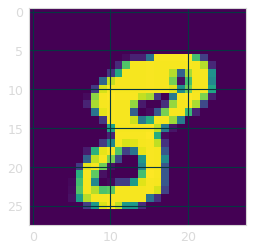

In [9]:
plt.imshow(train_x[10].squeeze())

The data can be augmented at runtime using the Keras ImageDataGenerator: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [10]:
datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    zoom_range=0.15)

# Model

Build up a model using the TF Keras functional API.

In [11]:
def create_model(checkpoint=None):
    inputs = Input(shape=(28, 28, 1))

    x = Conv2D(32, kernel_size=3, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=3, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Conv2D(64, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Conv2D(128, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Conv2D(256, kernel_size=2, activation='relu', )(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    if checkpoint is not None:
        model.load_weights(checkpoint)
    
    return model

In [12]:
model = create_model()

Learning rate annealing should help it converge faster.

In [13]:
def scheduler(epoch, lr):
    return 1e-3 * 0.9 ** epoch

lr_sched = LearningRateScheduler(scheduler)

# Train

The training predictors and responses should be split into a training and validation set.

In [14]:
train_x_split, val_x_split, train_y_split, val_y_split = model_selection.train_test_split(train_x, train_y, test_size = 0.1)

In [15]:
EPOCHS = 45
BATCH_SIZE = 64

model.fit_generator(
    datagen.flow(train_x_split, train_y_split, batch_size=BATCH_SIZE),
    steps_per_epoch=len(train_x_split) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[lr_sched],
    validation_data=(val_x_split, val_y_split))

Epoch 1/45
590/590 [==============================] - 35s 59ms/step - loss: 0.8909 - accuracy: 0.7127 - val_loss: 0.1191 - val_accuracy: 0.9657
Epoch 2/45
590/590 [==============================] - 33s 56ms/step - loss: 0.2691 - accuracy: 0.9201 - val_loss: 0.0985 - val_accuracy: 0.9738
Epoch 3/45
590/590 [==============================] - 33s 56ms/step - loss: 0.1787 - accuracy: 0.9479 - val_loss: 0.0453 - val_accuracy: 0.9864
Epoch 4/45
590/590 [==============================] - 33s 56ms/step - loss: 0.1389 - accuracy: 0.9606 - val_loss: 0.0454 - val_accuracy: 0.9881
Epoch 5/45
590/590 [==============================] - 33s 56ms/step - loss: 0.1169 - accuracy: 0.9660 - val_loss: 0.0405 - val_accuracy: 0.9886
Epoch 6/45
590/590 [==============================] - 33s 56ms/step - loss: 0.1080 - accuracy: 0.9703 - val_loss: 0.0450 - val_accuracy: 0.9864
Epoch 7/45
590/590 [==============================] - 33s 56ms/step - loss: 0.0983 - accuracy: 0.9718 - val_loss: 0.0321 - val_accuracy:

In [16]:
model.save_weights('./model.ckpt')

predictions = pd.Series(np.argmax(model.predict(test_x), axis=1), name='Label')
image_id = pd.Series(np.arange(1, len(test_x) + 1), name='ImageId')

submit = pd.concat([image_id, predictions], axis=1)
submit.to_csv('digit_pred.csv', index=False)

## Ensemble method

As shown [here](https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist), ensembling multiple models can get a higher accuracy due to the random nature of each round of model training.

In [18]:
ENSEMBLE_COUNT = 10

models = []
models.append(model) # use the original model as well

for i in range(ENSEMBLE_COUNT):
    train_x_split, val_x_split, train_y_split, val_y_split = model_selection.train_test_split(train_x, train_y, test_size = 0.1)
    
    model = create_model()
    stat = model.fit_generator(
        datagen.flow(train_x_split, train_y_split, batch_size=BATCH_SIZE),
        steps_per_epoch=len(train_x_split) // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[lr_sched],
        validation_data=(val_x_split, val_y_split))
    
    model.save_weights(f"./model-{i}.ckpt")
    
    print(f"Model {i} Final - Train acc: {stat.history['accuracy'][-1]}, Validation acc: {stat.history['val_accuracy'][-1]}")
    
    models.append(model)

Model 0 - Train acc: 0.9925317764282227, Validation acc: 0.996666669845581
Model 1 - Train acc: 0.9930040240287781, Validation acc: 0.9961904883384705
Model 2 - Train acc: 0.992792010307312, Validation acc: 0.994523823261261
Model 3 - Train acc: 0.9919970035552979, Validation acc: 0.9957143068313599
Model 4 - Train acc: 0.9921030402183533, Validation acc: 0.9959523677825928
Model 5 - Train acc: 0.9930570125579834, Validation acc: 0.9947618842124939
Model 6 - Train acc: 0.9933750033378601, Validation acc: 0.9959523677825928
Model 7 - Train acc: 0.9921825528144836, Validation acc: 0.9950000047683716
Model 8 - Train acc: 0.9927125573158264, Validation acc: 0.9954761862754822
Model 9 - Train acc: 0.9935911297798157, Validation acc: 0.9952380657196045


In [19]:
predictions = np.zeros((len(test_x), 10))

for m in models:
    predictions += m.predict(test_x)
    
predictions = pd.Series(np.argmax(predictions, axis=1), name='Label')
image_id = pd.Series(np.arange(1, len(test_x) + 1), name='ImageId')

submit = pd.concat([image_id, predictions], axis=1)
submit.to_csv('digit_pred_ensemble.csv', index=False)

## Compare

In [20]:
single_result = pd.read_csv('./digit_pred.csv')
ensemble_result = pd.read_csv('./digit_pred_ensemble.csv')

diff = pd.merge(single_result, ensemble_result, how='outer', on='ImageId')
diff = diff[diff['Label_x'] != diff['Label_y']]

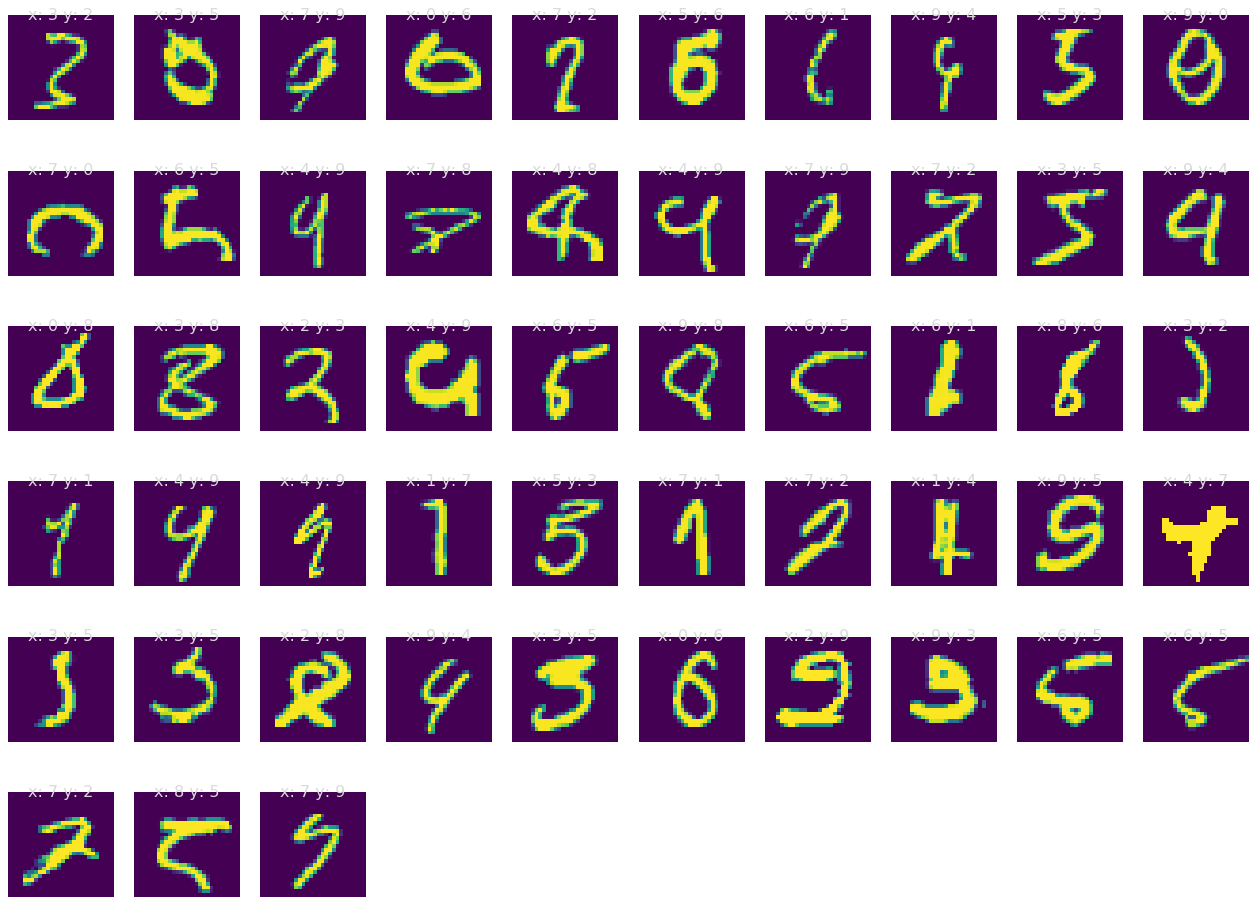

In [46]:
import math

plt.figure(figsize=(20,15), dpi=80)
for i in range(len(diff)):
    plt.subplot(math.ceil(len(diff) / 10), 10, i + 1)
    plt.imshow(test_x[diff.iloc[i]['ImageId'] - 1].squeeze())
    plt.title(f"x: {diff.iloc[i]['Label_x']} y: {diff.iloc[i]['Label_y']}", y=0.9)
    plt.axis('off')